In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

color_pal = sns.color_palette()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dj-xgb-1/dow_data.csv
/kaggle/input/egx-30/EGX 30 Data June.csv


In [2]:
df = pd.read_csv("/kaggle/input/egx-30/EGX 30 Data June.csv")
df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/05/2024,"26,634.30","26,915.46","26,915.46","26,245.33",240.86M,-1.26%
1,06/04/2024,"26,973.00","26,852.33","27,158.65","26,852.33",352.59M,0.52%
2,06/03/2024,"26,834.47","26,869.85","27,003.04","26,760.84",267.86M,-0.13%
3,06/02/2024,"26,869.85","26,922.76","27,140.20","26,753.70",225.28M,-0.20%
4,05/30/2024,"26,922.76","27,089.68","27,116.25","26,683.97",352.59M,-0.62%
...,...,...,...,...,...,...,...
3704,03/05/2009,"3,575.93","3,566.55","3,605.23","3,565.60",54.81M,0.47%
3705,03/04/2009,"3,559.09","3,524.63","3,562.48","3,524.63",68.90M,1.19%
3706,03/03/2009,"3,517.33","3,524.81","3,533.41","3,494.95",57.01M,-1.88%
3707,03/02/2009,"3,584.86","3,640.55","3,641.19","3,584.86",46.91M,-1.70%


In [3]:
def convert_volume_to_float(volume_str):
    if pd.isna(volume_str):
        return np.nan
    else:
        return float(volume_str[:-1]) * 1e6

def convert_change_to_float(change_str):
    if pd.isna(change_str):
        return np.nan
    else:
        return float(change_str[:-1]) /100

**Changing string values to float**

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

num_cols = ['Price', 'Open', 'High', 'Low']
for col in num_cols:
    df[col] = df[col].str.replace(',', '').astype(float)

df['Vol.'] = df['Vol.'].apply(convert_volume_to_float)
df['Change %']= df['Change %'].apply(convert_change_to_float)
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-05,26634.30,26915.46,26915.46,26245.33,240860000.0,-0.0126
2024-06-04,26973.00,26852.33,27158.65,26852.33,352590000.0,0.0052
2024-06-03,26834.47,26869.85,27003.04,26760.84,267860000.0,-0.0013
2024-06-02,26869.85,26922.76,27140.20,26753.70,225280000.0,-0.0020
2024-05-30,26922.76,27089.68,27116.25,26683.97,352590000.0,-0.0062
...,...,...,...,...,...,...
2009-03-05,3575.93,3566.55,3605.23,3565.60,54810000.0,0.0047
2009-03-04,3559.09,3524.63,3562.48,3524.63,68900000.0,0.0119
2009-03-03,3517.33,3524.81,3533.41,3494.95,57010000.0,-0.0188


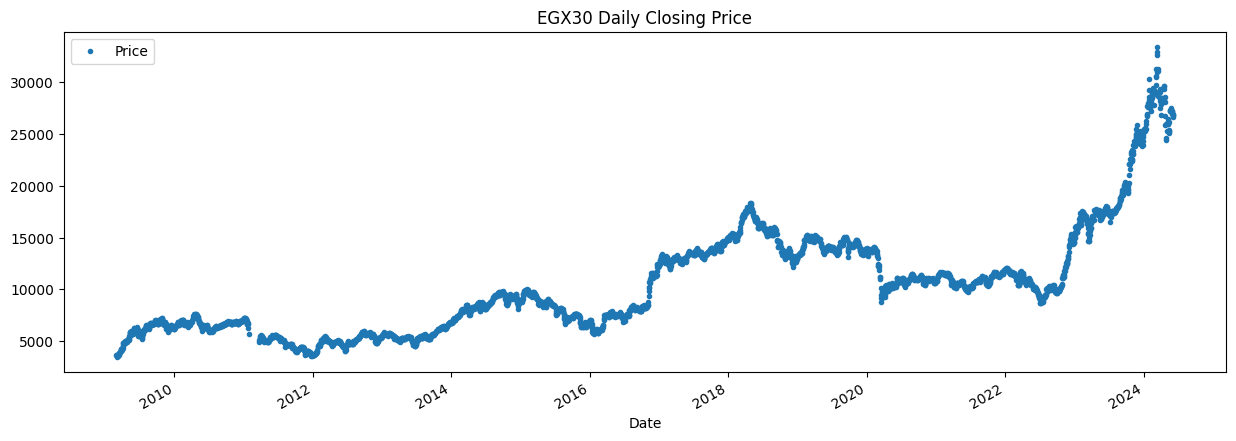

In [5]:
df.plot(y='Price', figsize=(15,5), color= color_pal[0],
        title='EGX30 Daily Closing Price', use_index=True, style='.')
plt.show()

In [6]:
def create_lag_features(df,col,lags):
    """
    Create time series features based on time series index.
    """
    df = df.sort_index()
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    for lag in lags:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    df = df.sort_index(ascending= False)
    return df


lags = [x for x in range(1,61)]
aug_df = create_lag_features(df,'Price', lags)
aug_df = aug_df.loc[aug_df.index > '05-27-2009']
aug_df

,Price,Open,High,Low,Vol.,Change %,quarter,year,Price_lag_1,Price_lag_2,...,Price_lag_51,Price_lag_52,Price_lag_53,Price_lag_54,Price_lag_55,Price_lag_56,Price_lag_57,Price_lag_58,Price_lag_59,Price_lag_60
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-05,26634.30,26915.46,26915.46,26245.33,240860000.0,-0.0126,2,2024,26973.00,26834.47,...,31061.88,31316.43,31013.88,32661.61,33382.51,32919.95,31300.54,29743.11,30668.89,30542.33
2024-06-04,26973.00,26852.33,27158.65,26852.33,352590000.0,0.0052,2,2024,26834.47,26869.85,...,31316.43,31013.88,32661.61,33382.51,32919.95,31300.54,29743.11,30668.89,30542.33,29058.33
2024-06-03,26834.47,26869.85,27003.04,26760.84,267860000.0,-0.0013,2,2024,26869.85,26922.76,...,31013.88,32661.61,33382.51,32919.95,31300.54,29743.11,30668.89,30542.33,29058.33,28964.41
2024-06-02,26869.85,26922.76,27140.20,26753.70,225280000.0,-0.0020,2,2024,26922.76,27089.68,...,32661.61,33382.51,32919.95,31300.54,29743.11,30668.89,30542.33,29058.33,28964.41,28876.46
2024-05-30,26922.76,27089.68,27116.25,26683.97,352590000.0,-0.0062,2,2024,27089.68,27194.51,...,33382.51,32919.95,31300.54,29743.11,30668.89,30542.33,29058.33,28964.41,28876.46,29205.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-06-03,6174.25,6202.16,6222.69,6159.58,129100000.0,-0.0129,2,2009,6255.07,6088.65,...,3982.28,3965.80,3914.65,3814.93,3780.84,3819.56,3700.76,3712.82,3627.77,3587.46
2009-06-02,6255.07,6241.13,6305.31,6240.59,180780000.0,0.0273,2,2009,6088.65,5926.44,...,3965.80,3914.65,3814.93,3780.84,3819.56,3700.76,3712.82,3627.77,3587.46,3575.93
2009-06-01,6088.65,5999.38,6088.65,5998.29,119590000.0,0.0274,2,2009,5926.44,5665.32,...,3914.65,3814.93,3780.84,3819.56,3700.76,3712.82,3627.77,3587.46,3575.93,3559.09


In [7]:
close_df = aug_df.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])
close_df

,Price,quarter,year,Price_lag_1,Price_lag_2,Price_lag_3,Price_lag_4,Price_lag_5,Price_lag_6,Price_lag_7,...,Price_lag_51,Price_lag_52,Price_lag_53,Price_lag_54,Price_lag_55,Price_lag_56,Price_lag_57,Price_lag_58,Price_lag_59,Price_lag_60
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-05,26634.30,2,2024,26973.00,26834.47,26869.85,26922.76,27089.68,27194.51,27287.31,...,31061.88,31316.43,31013.88,32661.61,33382.51,32919.95,31300.54,29743.11,30668.89,30542.33
2024-06-04,26973.00,2,2024,26834.47,26869.85,26922.76,27089.68,27194.51,27287.31,27539.21,...,31316.43,31013.88,32661.61,33382.51,32919.95,31300.54,29743.11,30668.89,30542.33,29058.33
2024-06-03,26834.47,2,2024,26869.85,26922.76,27089.68,27194.51,27287.31,27539.21,27205.14,...,31013.88,32661.61,33382.51,32919.95,31300.54,29743.11,30668.89,30542.33,29058.33,28964.41
2024-06-02,26869.85,2,2024,26922.76,27089.68,27194.51,27287.31,27539.21,27205.14,27227.44,...,32661.61,33382.51,32919.95,31300.54,29743.11,30668.89,30542.33,29058.33,28964.41,28876.46
2024-05-30,26922.76,2,2024,27089.68,27194.51,27287.31,27539.21,27205.14,27227.44,27224.80,...,33382.51,32919.95,31300.54,29743.11,30668.89,30542.33,29058.33,28964.41,28876.46,29205.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-06-03,6174.25,2,2009,6255.07,6088.65,5926.44,5665.32,5869.37,5871.08,5789.65,...,3982.28,3965.80,3914.65,3814.93,3780.84,3819.56,3700.76,3712.82,3627.77,3587.46
2009-06-02,6255.07,2,2009,6088.65,5926.44,5665.32,5869.37,5871.08,5789.65,5767.81,...,3965.80,3914.65,3814.93,3780.84,3819.56,3700.76,3712.82,3627.77,3587.46,3575.93
2009-06-01,6088.65,2,2009,5926.44,5665.32,5869.37,5871.08,5789.65,5767.81,5699.52,...,3914.65,3814.93,3780.84,3819.56,3700.76,3712.82,3627.77,3587.46,3575.93,3559.09


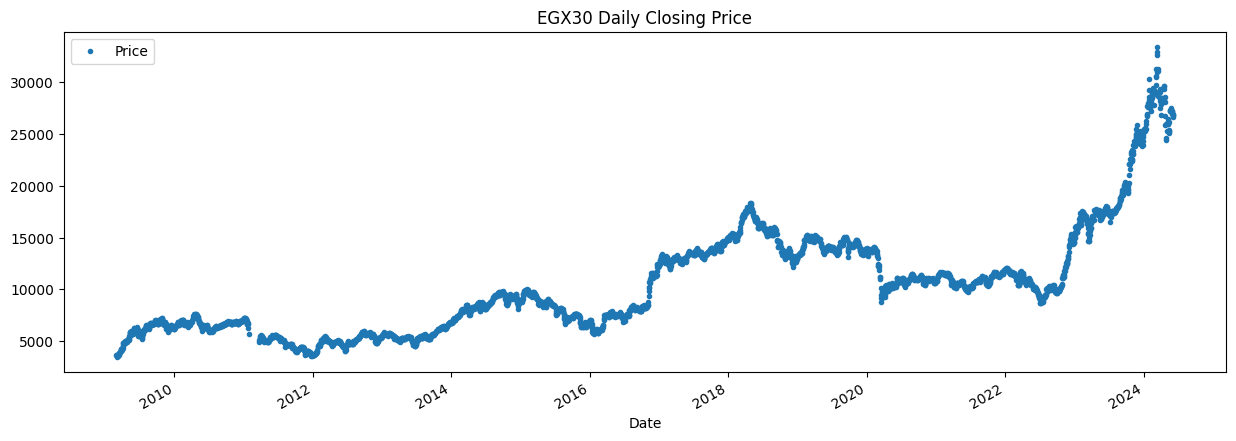

In [8]:
df.plot(y='Price', figsize=(15,5), color= color_pal[0],
        title='EGX30 Daily Closing Price', use_index=True, style='.')
plt.show()

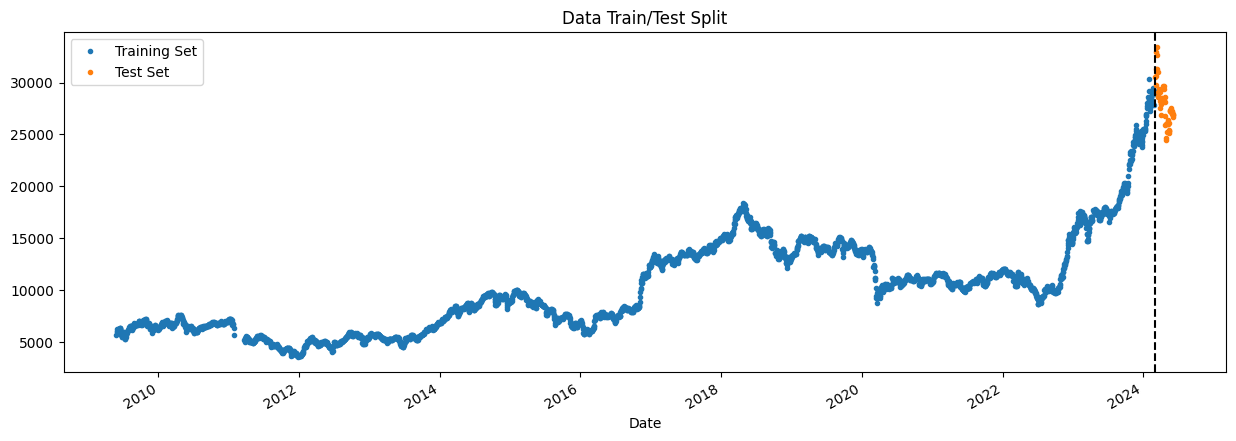

In [9]:
train = aug_df.loc[aug_df.index < '03-04-2024']
test = aug_df.loc[aug_df.index >= '03-04-2024']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, y='Price', label='Training Set', title= 'Data Train/Test Split', style='.')
test.plot(ax=ax, y='Price', label='Test Set', style='.')
ax.axvline('03-04-2024', color='black', ls='--')
plt.show()

train_features = [f'Price_lag_{x}' for x in range(1, 61)]

X_train = train[train_features]
Y_train = train['Price']

X_test = test[train_features]
Y_test = test['Price']

In [11]:
#Normalize Data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.fit_transform(X_test)

Y_train_scaled = target_scaler.fit_transform(Y_train.values.reshape(-1, 1)).flatten()
Y_test_scaled = target_scaler.fit_transform(Y_test.values.reshape(-1, 1)).flatten()

test.loc[:,'Price_scaled'] = Y_test_scaled

In [13]:
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=400,
                       early_stopping_rounds=10,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01,
                       random_state=59)
model.fit(X_train_scaled, Y_train_scaled, eval_set=[(X_train_scaled, Y_train_scaled), (X_test_scaled, Y_test_scaled)], verbose=50)

test.loc[:,'prediction_scaled'] = model.predict(X_test_scaled)
test.loc[:,'prediction'] = target_scaler.inverse_transform(test['prediction_scaled'].values.reshape(-1, 1)).flatten()

[0]	validation_0-rmse:0.30236	validation_1-rmse:0.24624
[50]	validation_0-rmse:0.18406	validation_1-rmse:0.17472
[100]	validation_0-rmse:0.11221	validation_1-rmse:0.13649
[150]	validation_0-rmse:0.06854	validation_1-rmse:0.11798
[200]	validation_0-rmse:0.04205	validation_1-rmse:0.11078
[250]	validation_0-rmse:0.02606	validation_1-rmse:0.10811
[300]	validation_0-rmse:0.01651	validation_1-rmse:0.10735
[350]	validation_0-rmse:0.01099	validation_1-rmse:0.10712
[379]	validation_0-rmse:0.00901	validation_1-rmse:0.10709


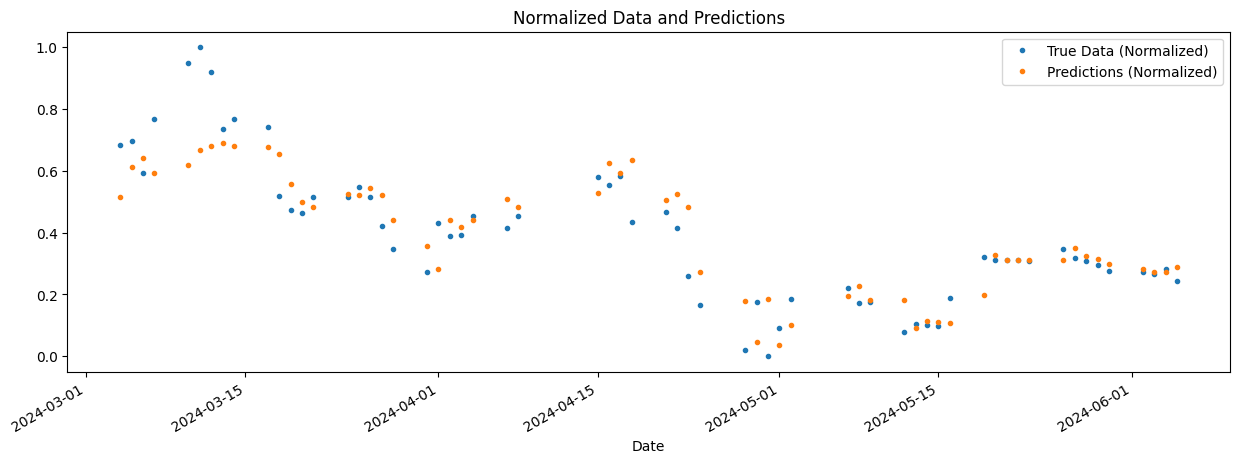

In [14]:
# Plot normalized data and predictions
fig, ax = plt.subplots(figsize=(15, 5))

# Plot true data
test['Price_scaled'].plot(ax=ax, style='.', label='True Data (Normalized)')

# Plot predictions
test['prediction_scaled'].plot(ax=ax, style='.', label='Predictions (Normalized)')

plt.legend()
plt.title('Normalized Data and Predictions')
plt.show()

In [15]:
np.sqrt(mean_squared_error(test['Price_scaled'], test['prediction_scaled']))

0.1070827160058821

In [16]:
#Not Normalized
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=600,
                       early_stopping_rounds=10,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01,
                       random_state=59)
reg.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_test, Y_test)], verbose=50)

[0]	validation_0-rmse:11098.44541	validation_1-rmse:27809.35555
[50]	validation_0-rmse:6747.86431	validation_1-rmse:17648.01931
[100]	validation_0-rmse:4106.05422	validation_1-rmse:11121.18237
[150]	validation_0-rmse:2501.44385	validation_1-rmse:7038.17938
[200]	validation_0-rmse:1527.57752	validation_1-rmse:4540.45059
[250]	validation_0-rmse:938.15797	validation_1-rmse:3057.18368
[300]	validation_0-rmse:583.66466	validation_1-rmse:2215.54019
[350]	validation_0-rmse:374.33210	validation_1-rmse:1773.59486
[400]	validation_0-rmse:255.64885	validation_1-rmse:1574.68502
[450]	validation_0-rmse:193.17916	validation_1-rmse:1503.85595
[500]	validation_0-rmse:163.19439	validation_1-rmse:1490.07199
[509]	validation_0-rmse:159.85827	validation_1-rmse:1490.62539


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=59, ...)

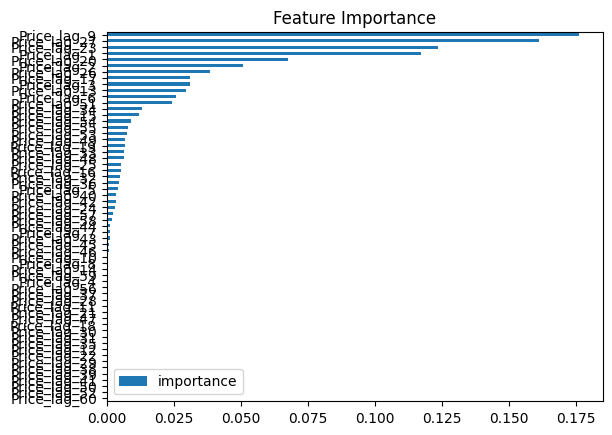

In [17]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

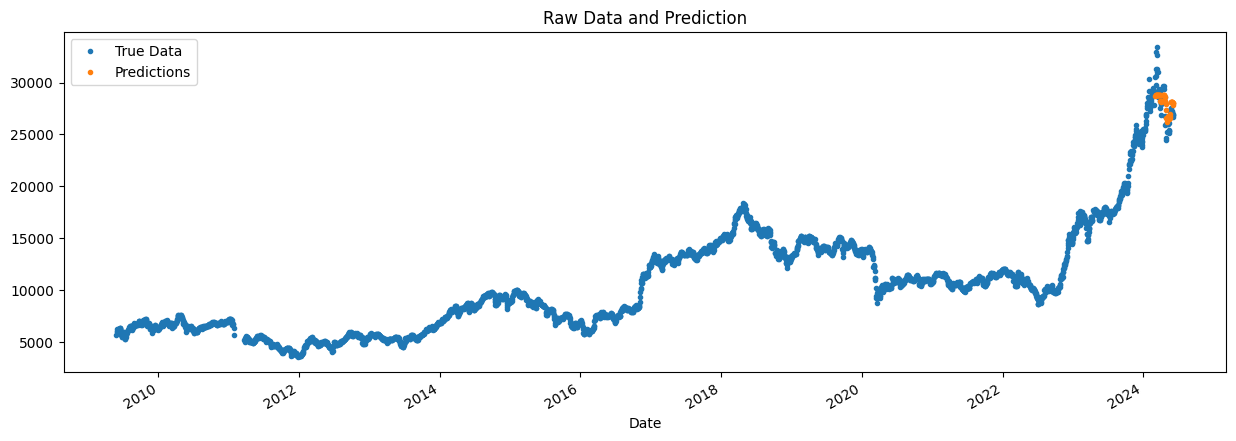

In [18]:
test.loc[:,'prediction'] = reg.predict(X_test)
aug_df = aug_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = aug_df[['Price']].plot(figsize=(15, 5), style='.')
aug_df['prediction'].plot(ax=ax, style='.')
plt.legend(['True Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [19]:
test['prediction'].head(40)

Date
2024-06-05    27785.144531
2024-06-04    27979.212891
2024-06-03    27979.212891
2024-06-02    27979.212891
2024-05-30    28124.300781
2024-05-29    28124.300781
2024-05-28    28124.300781
2024-05-27    28124.300781
2024-05-26    28124.300781
2024-05-23    28124.300781
2024-05-22    28124.300781
2024-05-21    26983.519531
2024-05-20    26758.892578
2024-05-19    26613.804688
2024-05-16    26497.162109
2024-05-15    26608.666016
2024-05-14    26609.632812
2024-05-13    26473.035156
2024-05-12    26749.207031
2024-05-09    26594.816406
2024-05-08    26749.207031
2024-05-07    26609.632812
2024-05-02    26492.994141
2024-05-01    26196.832031
2024-04-30    26609.632812
2024-04-29    27337.613281
2024-04-28    27889.988281
2024-04-24    28114.615234
2024-04-23    28124.300781
2024-04-22    28640.167969
2024-04-21    28259.703125
2024-04-18    28775.570312
2024-04-17    28775.570312
2024-04-16    28775.570312
2024-04-15    28775.570312
2024-04-08    28259.703125
2024-04-07    28775.570

In [20]:
np.sqrt(mean_squared_error(test['Price'], test['prediction']))

1490.0719902019632

In [21]:
avg_price = test['Price'].mean()
avg_price

27995.909344262294